In [2]:
import os
import sys

#Import config file. Update config.py according to your environment
import config

import pandas as pd
import numpy as np

import tensorflow as tf

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import MLClassifier

from src.utils.batch import fit_save_all
from src.utils.load import load_classifier

import ast

2024-03-11 08:28:02.689036: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 08:28:02.945302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 08:28:02.945370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 08:28:02.963225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 08:28:03.048690: I tensorflow/core/platform/cpu_feature_guar

In [48]:
clf1 = load_classifier('text/LinearSVC_tfidf')

In [46]:
df_results = pd.read_csv(os.path.join(config.path_to_results, 'results_benchmark_text.csv'))
#convert strings as numpy array where necessary
df_results['conf_mat_test'] = df_results['conf_mat_test'].apply(ast.literal_eval).apply(np.array)
df_results['probs_test'][~df_results['probs_test'].isna()] = df_results['probs_test'][~df_results['probs_test'].isna()].apply(ast.literal_eval).apply(np.array)
df_results['pred_test'] = df_results['pred_test'].apply(ast.literal_eval).apply(np.array)
df_results['y_test'] = df_results['y_test'].apply(ast.literal_eval).apply(np.array)

display(df_results)

/tmp/ipykernel_17931/3634201796.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,modality,class,vectorization,classifier,tested_params,best_params,score_test,score_test_cat,conf_mat_test,score_train,fit_time,score_cv_test,score_cv_train,fit_cv_time,probs_test,pred_test,y_test,model_path
0,0,text,MLClassifier,tfidf,LinearSVC,"{'C': [0.8, 0.9, 1.0, 1.1], 'penalty': ['l2']}",NaN,0.825352,"[0.5201938610662359, 0.7850467289719626, 0.932...","[[322, 3, 8, 1, 10, 5, 4, 0, 2, 5, 2, 1, 1, 2,...",0.978203,5.301483,NaN,NaN,NaN,NaN,"[7, 11, 20, 2, 16, 22, 13, 20, 17, 23, 19, 15,...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",text/LinearSVC_tfidf


In [38]:
recall_mat = df_results.loc[0, 'conf_mat_test']/ df_results.loc[0, 'conf_mat_test'].sum(axis=1)
precision_mat = df_results.loc[0, 'conf_mat_test']/ df_results.loc[0, 'conf_mat_test'].sum(axis=0)

f1score = 2 * np.diag(precision_mat * recall_mat) / np.diag(precision_mat + recall_mat)
f1score

array([0.52019386, 0.78504673, 0.93259122, 0.65648855, 0.68994709,
       0.62096774, 0.92015209, 0.9689441 , 0.82030457, 0.84018987,
       0.8365243 , 0.90503432, 0.91343284, 0.8132739 , 0.89589905,
       0.77371542, 0.76361713, 0.78397213, 0.94135189, 0.7388664 ,
       0.97336562, 0.82877406, 0.69771689, 0.96253602, 0.70041322,
       0.8173913 , 0.86451613])

In [33]:
print(clf1.classification_results)

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       623
           1       0.78      0.79      0.79       534
           2       0.91      0.95      0.93       791
           3       0.79      0.56      0.66       153
           4       0.71      0.67      0.69       974
           5       0.70      0.56      0.62       414
           6       0.88      0.96      0.92      1009
           7       0.97      0.97      0.97       161
           8       0.83      0.81      0.82       498
           9       0.86      0.82      0.84       648
          10       0.83      0.84      0.84      1015
          11       0.89      0.92      0.91       861
          12       0.88      0.95      0.91       161
          13       0.80      0.82      0.81       999
          14       0.93      0.86      0.90       165
          15       0.73      0.82      0.77       952
          16       0.77      0.76      0.76       955
          17       0.78    

<Axes: >

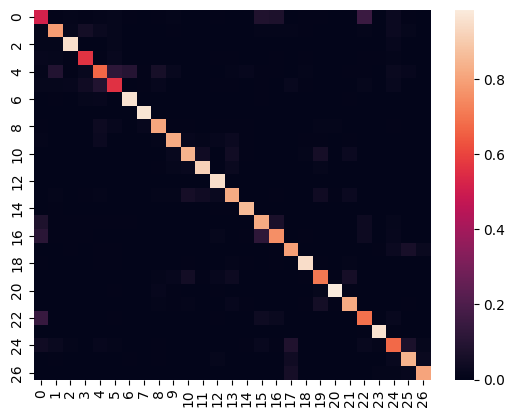

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_results.loc[0, 'conf_mat_test']/ df_results.loc[0, 'conf_mat_test'].sum(axis=1))

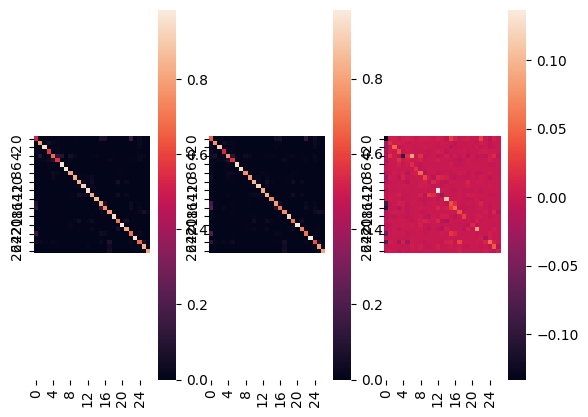

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
sns.heatmap(clf1.confusion_mat / clf1.confusion_mat.sum(axis=1))
plt.axis('equal')
plt.subplot(1, 3, 2)
sns.heatmap(clf2.confusion_mat / clf1.confusion_mat.sum(axis=1))
plt.axis('equal')
plt.subplot(1, 3, 3)
sns.heatmap((clf1.confusion_mat - clf2.confusion_mat) / clf1.confusion_mat.sum(axis=1))
plt.axis('equal')

plt.show()